# Model Project

**Table of contents**<a id='toc0_'></a>  
- [1. Objective](#toc1_)
- [2. Import of packages](#toc2_)
- [3. Model description](#toc3_)
- [4. Analytical solution](#toc4_)
- [5. Numerical solution](#toc5_)
- [6. Further analysis](#toc6_)
- [7. Concluding remarks](#toc7_)

## 1. <a id='toc1_'></a>[Objectives](#toc1_)

This notebook examines the OLG model, and look at how population growth affects the outcome of the model.

## 2. <a id='toc2_'></a>[Import of packages](#toc2_)

In [16]:
import numpy as np
from scipy import optimize
import sympy as sm
from types import SimpleNamespace

%load_ext autoreload
%autoreload 2

import ipywidgets as widgets

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 3. <a id='toc3_'></a>[Model description](#toc3_)

## The OLG Model 

The OLG model consists of 2 periods and 2 groups, young and old. The production function is a standard Cobb-Douglas function:
$$
Y_{t}=AK_{t}^{\alpha}L_{t}^{1-\alpha}
$$
with $t=1,2$ and $1>\alpha>0$. $K$ is capital and $L$ is the labor force which consists entirely of the young population. 
\
\
Capital accumulation is equal to how much is being saved in the economy. Note that it is only the young people who save:
$$
K_{t+1}=s_{t}L_{t}
$$
for simplicity, we assume that capital does not depreciate, $\delta=0$.
\
\
$L_{t}$ is the number of people born in period $t$, which grow at the constant rate, $n$:
$$
L_{t+1}=L_{t}(1+n)
$$


The firms have the profit maximization problem: 
$$
\underset{K_{t}L_{t}}{max}\quad AK_{t}^{\alpha}L_{t}^{1-\alpha}-r_{t}K_{t}-w_{t}L_{t}
$$
with $r_{t}$ and $w_{t}$ being the factor prices. We now that the standard solutions for factor prices in a Cobb-Douglas production function:
$$
r_{t}=A\alpha k_{t}^{\alpha-1}
$$
$$
w_{t}=A(1-\alpha)k_{t}^{\alpha}
$$
with A being the factor productivity, $A>0$. $k_t$ is capital per capita, $k_{t}=\frac{K_{t}}{L_{t}}$


The agents in the economy get utility from consuming:
$$
U_{t}=ln(c_{1t})+\beta ln(c_{2t+1})
$$
with $c_{1t}$ being consumption when young, and $c_{2t+1}$ when old. $\beta=\frac{1}{1+\rho}$, with $\rho$ being the discount rate, $\rho>-1$, ensuring the parameter $\beta$ is positive.

The agents have budget constraints,
$$
c_{1t}+s_{t}=w_{t}
$$
$$
c_{2t+1}=(1+r_{t+1})s_{t}
$$
The young agents consume their wages minus what they save, while the old consume their savings with interests. This yield the lifetime budget constraint, 
$$
c_{1t}+\frac{c_{2t+1}}{1+r_{t+1}}=w_{t}
$$

The basics of the model is now in place. Next step is to solve the household maximization problem:
$$
\underset{c_{1t},c_{2t+1}}{max}\quad ln(c_{1t})+\beta ln(c_{2t+1}) \quad s.t. \quad c_{1t}+\frac{c_{2t+1}}{1+r_{t+1}}=w_{t}
$$
The problem is solved with Lagrange and yields the Euler-equation:
$$
c_{2t+1}=\frac{1+r_{t+1}}{1+\rho}c_{1t}
$$

Combining the Euler-equation with the budget constraints, we obtain the optimal saving:
$$
s_{t}=\frac{1}{2+\rho}w_{t}
$$
Using that $s_{t}=k_{t+1}(1+n)$, we can find the capital accumulation per capita:
$$
k_{t+1}(1+n)=\frac{1}{2+\rho}w_{t}
$$
$$
\Leftrightarrow
$$
$$
k_{t+1}=\frac{A(1-\alpha)k_{t}^{\alpha}}{(1+n)(2+\rho)}
$$

In steady state we have that, $k_{t+1}=k_{t}=k^{*}$:
$$
k^{*}=(\frac{A(1-\alpha)}{(1+n)(2+\rho)})^{\frac{1}{1-\alpha}}
$$

## 4. <a id='toc4_'></a>[Analytical solution](#toc4_)

In this part we will set up the relevant parameters (sm.symbols), solve for steady state(sm.solve), and turn our function into a Python-function (sm.lambdify)

In [17]:
alpha = sm.symbols('alpha')
rho =  sm.symbols('rho')
k = sm.symbols('k')
n = sm.symbols('n')
A = sm.symbols('A')

In [18]:
ss = sm.Eq(k, (A*(1-alpha)*k**alpha)/((1+n)*(2+rho)))
ss

Eq(k, A*k**alpha*(1 - alpha)/((n + 1)*(rho + 2)))

In [19]:
ss_solve = sm.solve(ss, k)[0]
ss_solve

(A*(1 - alpha)/(n*rho + 2*n + rho + 2))**(-1/(alpha - 1))

which is equivalent to the steady state derived in part 3.

In [20]:
k_solve = sm.lambdify((alpha,rho,n,A),ss_solve)
k_solve(1/3,0.05,0.04,1)

0.17485671329443958

With our analytical solution, we get that capital per capita is 0.175 in steady state. 

## 5. <a id='toc5_'></a>[Numerical solution](#toc5_)

Next, we solve numerically. First, we define the values for our set of parameters used in the analysis.





In [21]:
# We define the values for our set of parameters
rho = 0.05
A = 1.00
alpha = 1/3
n = 0.04
tau = 0.00

ks_1 = ((A*(1-alpha))/((1+n)*(2+rho)))**(-1/(alpha-1))


In [22]:
# Defining the objective
obj = lambda k: k - ((A*(1-alpha)*k**alpha)/((1+n)*(2+rho)))

# Optimizing the model and finding the roots
result = optimize.root_scalar(obj,bracket=[1e-10,10],method='bisect') 
result.root

0.17485671329430136

Hence, with our numerical analaysis and based on the given parameter values, we also find the steady state to be 0.175.

Since $k_{t+1}$ is a concave function of $k_{t}$ , a unique steady state exists, and convergence to it will occur

In [25]:
#This code initiates the simulation of the model. 
from modelproject import modelclass

model = modelclass()
par = model.par
sim = model.sim

model.sim.results()

AttributeError: 'types.SimpleNamespace' object has no attribute 'results'

Both young and old individuals consume more in period $t$ compared to period 0. The consumption of the young increases from 0.186 in period 0 to 0.205 in period $t$, while the consumption of the old rises from 0.255 in period 0 to 0.294 in period $t$. In both periods, the old consume more than the young.

The Euler error decreases from -2.308 before simulation to 0.00 after simulating the model. This error indicates how closely the Euler approximation matches the true result, demonstrating that the model is more accurate post-simulation. Furthermore, we observe convergence in the model.

simulation done in 0.003 secs


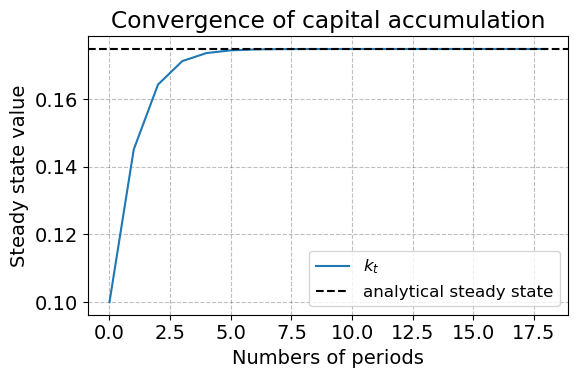

In [26]:
# a. Calling our simulation and storing new variables 
model.simulate()

# b. Plotting the simulation
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(model.sim.k,label=r'$k_{t}$') # Plotting k
ax.axhline(ks_1,ls='--',color='black',label='analytical steady state') # Plotting the analytical steady state
ax.legend(frameon=True,fontsize=12)
ax.set_title('Convergence of capital accumulation')
ax.set_xlabel('Numbers of periods')
ax.set_ylabel('Steady state value')
fig.tight_layout()
sim_k_old = model.sim.k.copy() # Creating a copy of the steady state simulation for later

The plot shows that the analytical steady state is around 0.175, which is consistent with the analytical and numerical solution found earlier in the project. 

Moreover, we observe that capital accumulation converges toward this steady state, taking approximately six simulations to do so.

## 6. <a id='toc6_'></a>[Further analysis](#toc6_)

### Effect of permanent unexpected increase in government spending

We want to examine what happens to capital accumulation if a government taxes households and spends resources (i.e government spendning increases). 

We consider the simplest case where the government makes "useless" purchases $G_t$ (per worker) and pays for them by imposing lump sum taxes $\tau_t$ (per worker) on the young each period, such that $p*n-w \neq p*n-c$

By this, the agent's budget constraints will change to:
$$
c_{1t}+s_{t}=w_{t}-\tau_t
$$
$$
c_{2t+1}=(1+r_{t+1})s_{t}
$$
As the only place where $\tau$ enters is in the young's income, we redefine $\tilde{w}_t=w_t-\tau_t$. Hence, from the saving equation from the model description section, we know that:
$$
s_t=\frac{1}{2+\rho}\tilde{w}_t
$$
and
$$
k_{t+1}=\frac{s_t}{1+n}=\frac{\tilde{w}_t}{(1+n)(2+\rho)}= \frac{(1-\alpha)k_t^{\alpha}-\tau_t}{(1+n)(2+\rho)}
$$
Which in equilibrium equals:
$$
k_{t+1}=\frac{(1-\alpha)k_t^{\alpha}-G_t}{(1+n)(2+\rho)}
$$

In [27]:
# Analytical steady state calculation
import sympy as sm
import numpy as np
from scipy import optimize
from modelproject import modelclass
import matplotlib.pyplot as plt

alpha, rho, n, A, k = sm.symbols('alpha rho n A k')
ss = sm.Eq(k, (A*(1-alpha)*k**alpha)/((1+n)*(2+rho)))
ss_solve = sm.solve(ss, k)[0]
k_solve = sm.lambdify((alpha, rho, n, A), ss_solve)
ks_1 = k_solve(1/3, 0.05, 0.04, 1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


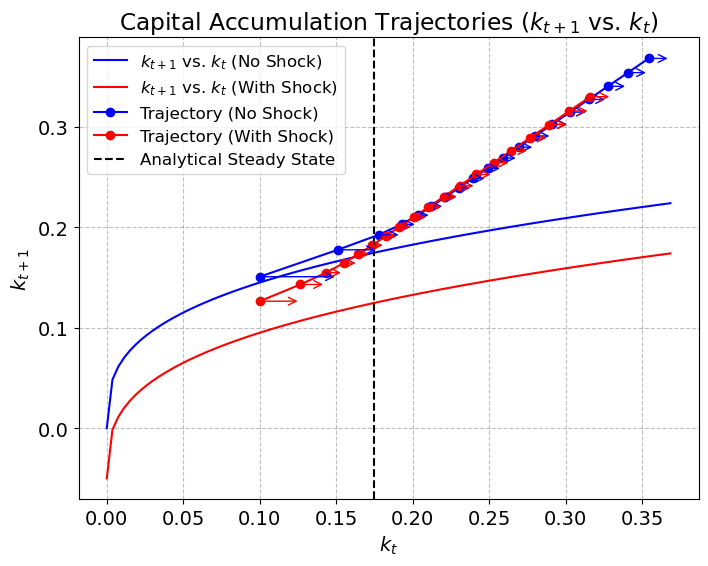

In [28]:
# Load autoreload extension
%load_ext autoreload
%autoreload 2

# Compare simulation results with and without shock
def compare_simulation_results():
    # Without shock
    model_no_shock = modelclass()
    model_no_shock.simulate(do_print=False)
    k_no_shock = model_no_shock.sim.K.copy()
    
    # With shock
    tau_shock = 0.1
    Gt_shock = 0.05
    model_shock = modelclass()
    model_shock.run_with_shock(tau_shock, Gt_shock)
    k_with_shock = model_shock.sim.K.copy()

    # Plot the convergence comparison
    model_shock.plot_k_vs_k(k_no_shock, k_with_shock, ks_1)

compare_simulation_results()


We see that capital falls. From the equilibrium capital accumulation equation previously written up for period $t+1$ we see an inverse relationship between government spendning, $G_t$ and capital accumulation, $k_{t+1}$, such that an increase in $G_t$ leads to a decrease in $k_{t+1}$. 

As it is only the the working-age generation that pay taxes in the OLS model, the tax will exclusively fall on the young generation (to finance government spendning). As a result, the present discounted value (PDV) of lifetime disposable income decreases for the young. 

Hence, the young generation seek to smooth their consumption over their lifetimes. And with a lower PDV of disposable lifetime income, the young generation adjusts by reducing their overall consumption. Given the structure of the Euler equation preseted earlier, to smooth consumption, the young must both reduce their consumption in period $t$ (when young) and in period $t+1$ (when old) - such that they save less today, which leads to a decrease in current savings. 

In the OLG model, savings directly translates to capital accumulation. So when individuals decrease savings, capital accumulation falls as dislayed by the figure above. 



## 7. <a id='toc7_'></a>[Concluding remarks](#toc7_)

In sum, the first figure shows the analytical steady state of approximately 0.175 in the absence of shocks. However, when subjected to an unexpected increase in government spending, achieved through lump-sum taxes levied per worker on the young each period, the capital accumulation decreases accordingly.